In [1]:
# pip install -U tensorflow-addons

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # cuda 사용시 check 필요1

In [3]:
"""
## Setup
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [4]:

"""
## Prepare the data
"""

num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:


"""
## Configure the hyperparameters
"""

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 200 # 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [6]:


"""
## Use data augmentation
"""

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size), 
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [7]:


"""
## Implement patch creation as a layer
"""
#Todo: here! change to CNN

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches




In [8]:
# patches = Patches(patch_size)(resized_image)

NameError: name 'resized_image' is not defined

In [ ]:
# patches.shape

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


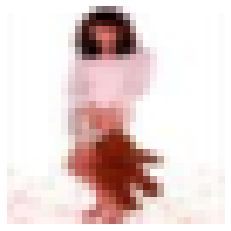

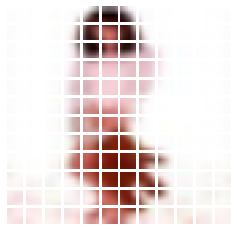

In [10]:

"""
Let's display patches for a sample image
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.show()

In [ ]:

# class Patches(layers.Layer):
#     def __init__(self, patch_size):
#         super(Patches, self).__init__()
#         self.patch_size = patch_size
#         self.conv = tf.keras.layers.Conv2D(3, patch_size, strides=(patch_size, patch_size), padding='SAME')
        
#     def call(self, images):
#         # using conv2d (not patch cutting)
#         batch_size = images.shape[0]
#         patches = self.conv(images)
# #         patches = tf.image.extract_patches(
# #             images=patches,
# #             sizes=[1, self.patch_size, self.patch_size, 1],
# #             strides=[1, self.patch_size, self.patch_size, 1],
# #             rates=[1, 1, 1, 1],
# #             padding="VALID",
# #         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches

In [ ]:
# patches = Patches(patch_size)(resized_image)

In [ ]:
# patches.shape

In [ ]:

# """
# Let's display patches for a sample image
# """

# import matplotlib.pyplot as plt

# plt.figure(figsize=(4, 4))
# image = x_train[np.random.choice(range(x_train.shape[0]))]
# plt.imshow(image.astype("uint8"))
# plt.axis("off")

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )
# patches = Patches(patch_size, image_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")
# plt.show()

In [11]:

"""
## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.
"""


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [12]:

"""
## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.
"""



"""
## Implement multilayer perceptron (MLP)
"""


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.LayerNormalization(epsilon=1e-6)(x) # EUNI
        x = layers.Dropout(dropout_rate)(x)
    return x


def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2) # EUNI
        # MLP.
        x3 = mlp(x2, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [13]:

"""
## Compile, train, and evaluate the mode
"""


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
#     wd_schedule = tf.keras.experimental.CosineDecay(weight_decay, num_epochs*((1+50000)//batch_size))
#     optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate*0.1, weight_decay=lambda : None, beta_1=0.999, beta_2=0.9999)
#     optimizer.weight_decay = lambda : wd_schedule(optimizer.iterations)

    # Models that contain convolutions or matrix multiplications using the tf.float16 data type will automatically take advantage of Tensor Core hardware whenever possible.
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)


    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, earlystop_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test) # top5..? oh..
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/200
176/176 [==============================] - 583s 3s/step - loss: 5.2758 - accuracy: 0.0153 - top-5-accuracy: 0.0703 - val_loss: 4.4544 - val_accuracy: 0.0442 - val_top-5-accuracy: 0.1622
Epoch 2/200
176/176 [==============================] - 572s 3s/step - loss: 4.4737 - accuracy: 0.0299 - top-5-accuracy: 0.1208 - val_loss: 4.2637 - val_accuracy: 0.0552 - val_top-5-accuracy: 0.2146
Epoch 3/200
176/176 [==============================] - 577s 3s/step - loss: 4.3344 - accuracy: 0.0432 - top-5-accuracy: 0.1676 - val_loss: 4.1326 - val_accuracy: 0.0776 - val_top-5-accuracy: 0.2424
Epoch 4/200
176/176 [==============================] - 576s 3s/step - loss: 4.2016 - accuracy: 0.0589 - top-5-accuracy: 0.2088 - val_loss: 4.0056 - val_accuracy: 0.0912 - val_top-5-accuracy: 0.2744
Epoch 5/200
176/176 [==============================] - 577s 3s/step - loss: 4.0781 - accuracy: 0.0722 - top-5-accuracy: 0.2467 - val_loss: 3.9040 - val_accuracy: 0.1062 - val_top-5-accuracy: 0.3114
Epoch 6/20

In [11]:
# This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
np.__version__, tf.__version__ # ('1.20.2', '2.4.1') >> # downgrade numpy 1.20.2 >> 1.19.5

('1.19.5', '2.4.1')

In [ ]:
# change optimizer & more epochs & early stopping >> 

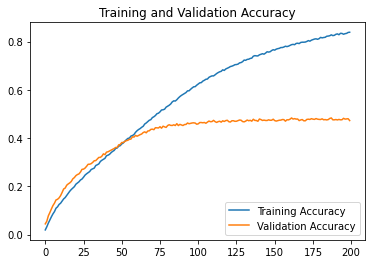

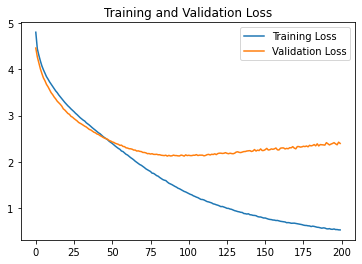

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(val_loss))  # early stopping


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# layernorm position >> worse

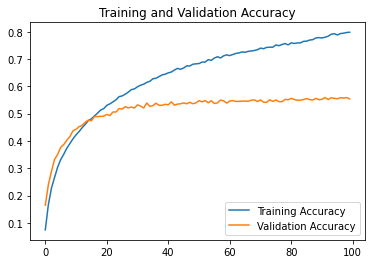

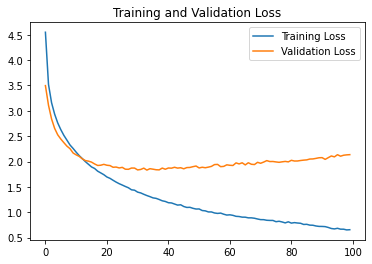

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## overfitting 30~: no trained!

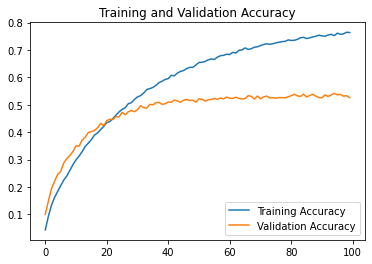

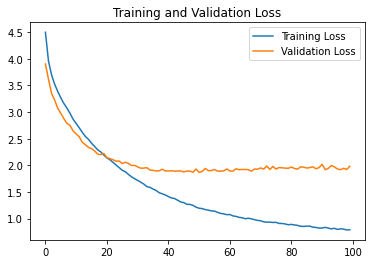

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## TODO

1. input >> CNN (pre-trained)
2. for Multi-modal
    : connect on transformer attention parts(NLP)